# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import os
import sys
import datetime
import operator as op

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 40

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
from utils import get_constants, get_features_list, run_with_time
from model import get_train_test_split, test_model
from visualization import eng_formatter, eng_formatter_full
from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

## Read datasets

In [4]:
%%time
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = get_features_list(df, constants)
refined_features_list = get_features_list(df_refined, constants)

CPU times: user 53.1 s, sys: 13.5 s, total: 1min 6s
Wall time: 5.06 s


In [5]:
%%time
df_sample = df.sample(20_000_000)
df_refined_sample = df_refined.loc[df_sample.index]

CPU times: user 42.5 s, sys: 4.29 s, total: 46.8 s
Wall time: 46.2 s


# 7+1 Classes

## Baseline

In [6]:
%%time
baseline_train_test = get_train_test_split(
    df_sample,
    features_list,
    target='general_label',
    train_frac=0.80
)

CPU times: user 22.8 s, sys: 3.3 s, total: 26.1 s
Wall time: 26.1 s


Training dataset size: 16.0M (80.0%).
Test dataset size: 4.0M (20.0%).
Execution time (Model fit): 0:06:52.662628
Execution time (Predict): 0:00:11.694707
              precision    recall  f1-score   support

      Benign      0.922     0.979     0.950     93924
  BruteForce      0.997     0.544     0.704      1086
        DDoS      1.000     1.000     1.000   2912487
         DoS      1.000     1.000     1.000    693163
       Mirai      1.000     1.000     1.000    225417
       Recon      0.906     0.836     0.869     30189
    Spoofing      0.913     0.871     0.892     41621
         Web      0.972     0.424     0.590      2113

    accuracy                          0.996   4000000
   macro avg      0.964     0.832     0.876   4000000
weighted avg      0.996     0.996     0.996   4000000

CPU times: user 2h 56min 57s, sys: 2min 24s, total: 2h 59min 22s
Wall time: 11min 19s


Pipeline(steps=[('model', RandomForestClassifier(n_jobs=40))])

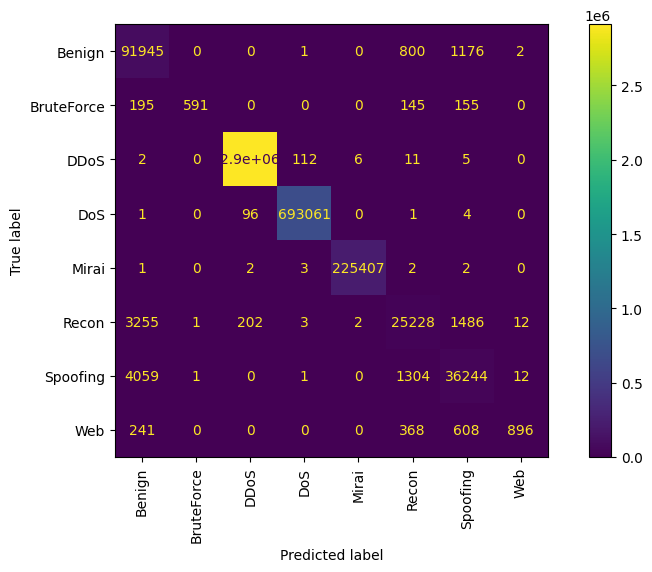

In [7]:
%%time
baseline_model = Pipeline([
    ('model', RandomForestClassifier(n_jobs=n_jobs))
])

test_model(baseline_model, *baseline_train_test)

# Multi-Stage Model

In [14]:
%%time
multi_stage_train_test = get_train_test_split(
    df_refined_sample,
    refined_features_list,
    target='general_label',
    train_frac=0.80
)

CPU times: user 30min 52s, sys: 10.7 s, total: 31min 2s
Wall time: 51.9 s


Training dataset size: 16.0M (80.0%).
Test dataset size: 4.0M (20.0%).
Execution time (Model fit): 0:10:40.331385
Execution time (Predict): 0:00:09.591160
              precision    recall  f1-score   support

      Benign      0.929     0.979     0.953     93924
  BruteForce      0.995     0.583     0.735      1086
        DDoS      1.000     1.000     1.000   2912487
         DoS      1.000     1.000     1.000    693163
       Mirai      1.000     1.000     1.000    225417
       Recon      0.909     0.856     0.882     30189
    Spoofing      0.926     0.880     0.902     41621
         Web      0.983     0.561     0.714      2113

    accuracy                          0.997   4000000
   macro avg      0.968     0.857     0.898   4000000
weighted avg      0.997     0.997     0.997   4000000

CPU times: user 5h 16min 21s, sys: 2min 11s, total: 5h 18min 33s
Wall time: 15min 5s


MultiStageClassifier(stages=[ModelStage(model=RandomForestClassifier(n_jobs=40), labels={'DoS', 'DDoS', 'Mirai'}),
                             ModelStage(model=RandomForestClassifier(max_features=10, n_jobs=40), labels={'Spoofing', 'Benign', 'Recon', 'Web', 'BruteForce'})])

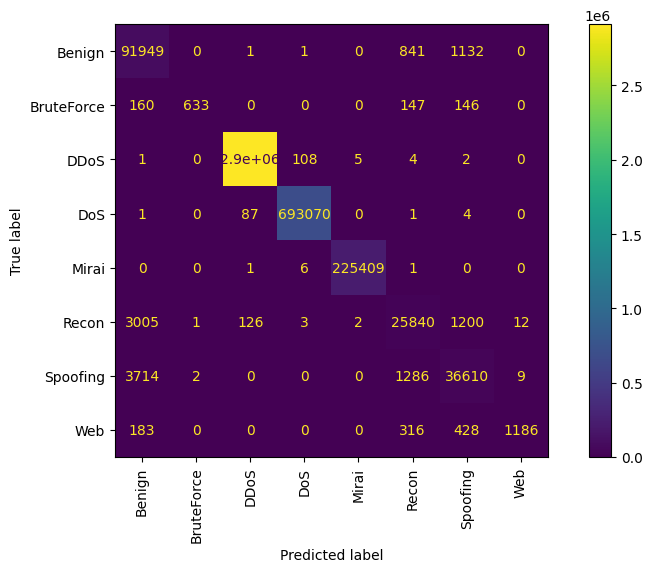

In [15]:
%%time
multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            # model=LGBMClassifier(class_weight='balanced', n_jobs=n_jobs, verbose=0),
            model=RandomForestClassifier(n_jobs=n_jobs),
            labels={'DDoS', 'DoS', 'Mirai'}
        ),
        ModelStage(
            model=RandomForestClassifier(max_features=10, n_jobs=n_jobs),
            labels={'Spoofing', 'Recon', 'Web', 'BruteForce', 'Benign'}
        ),
    ]
)

test_model(multi_stage_model, *multi_stage_train_test)